In [1]:
# !pip install -q xgboost==2.0.3

In [2]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
MERGED_DIR = Path("merged_energy_temp")
files       = sorted([f for f in MERGED_DIR.glob("*_merged.csv")])
assert files, f"No *_merged.csv found in {MERGED_DIR.resolve()}"

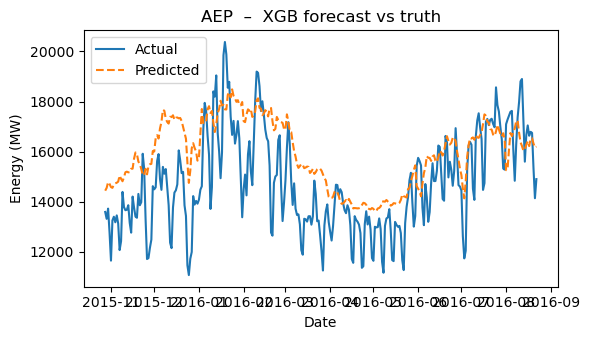

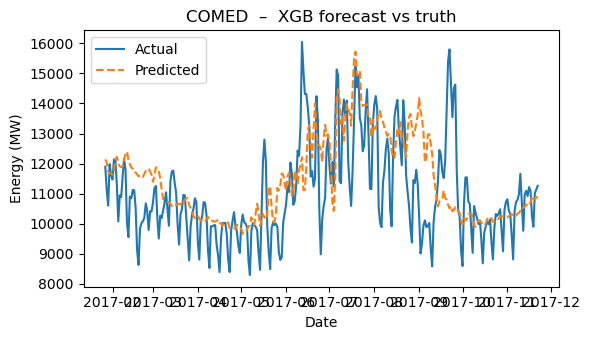

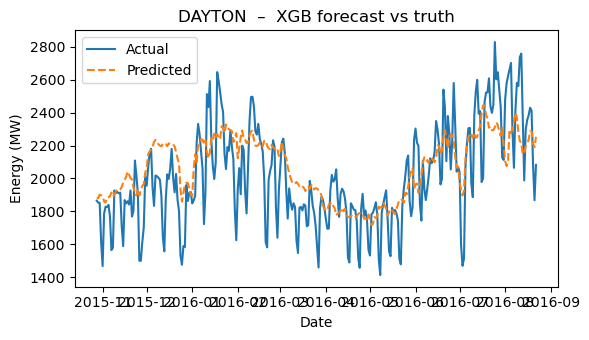

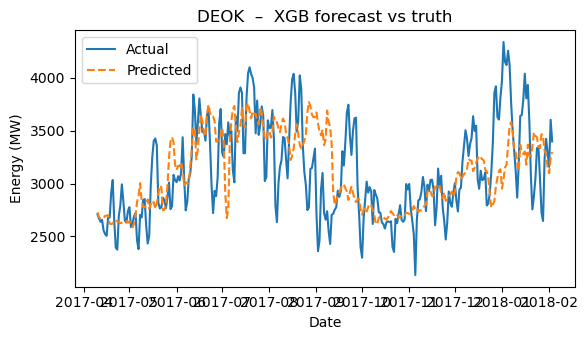

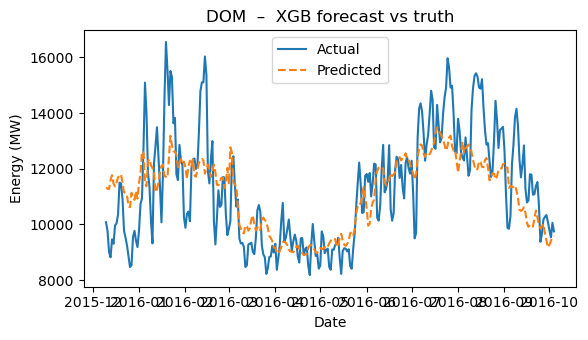

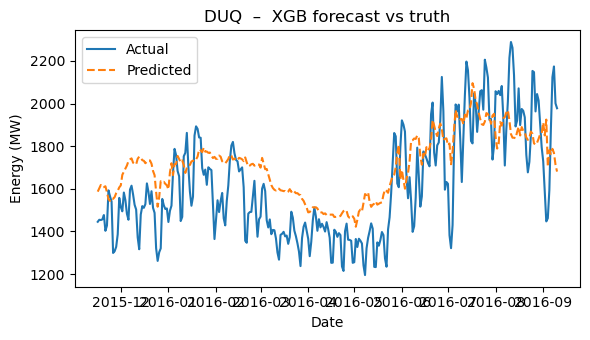

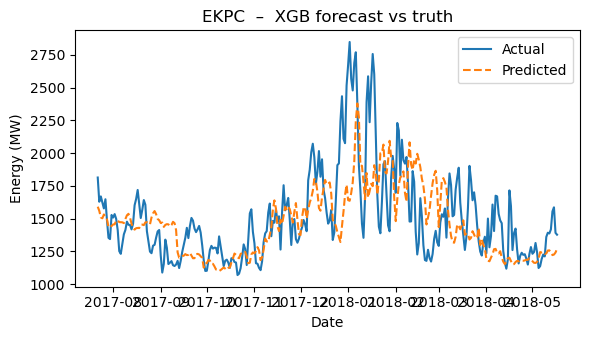

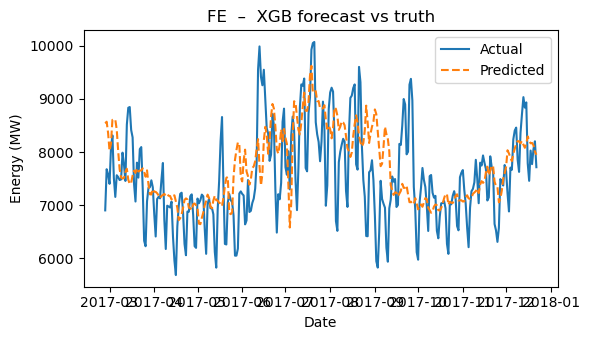

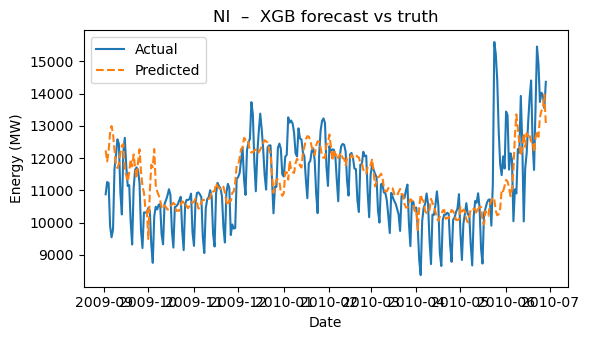

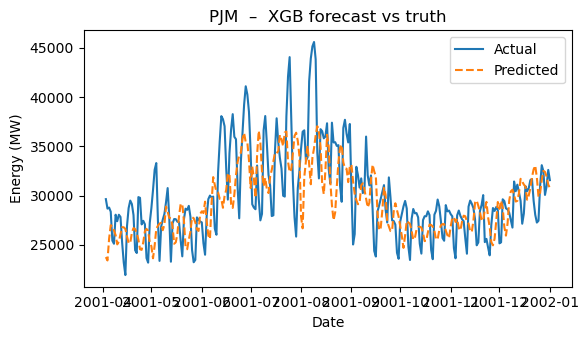

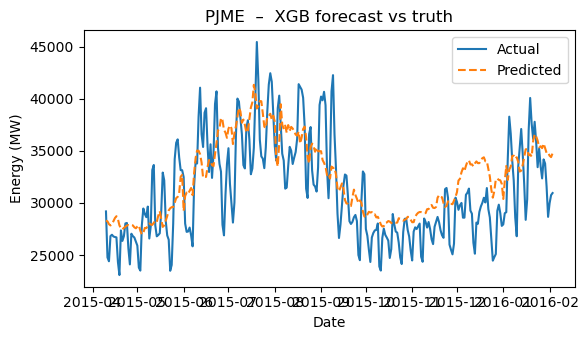

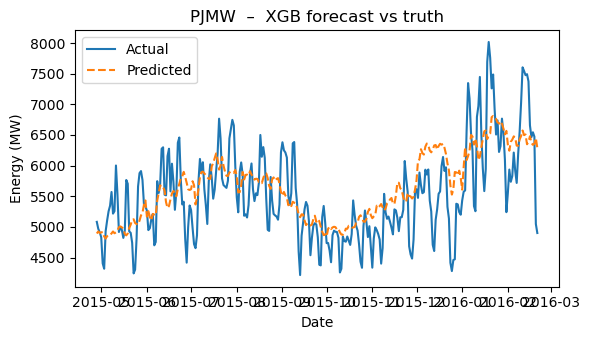

In [4]:
MAX_LAG          = 3               # temperature lags (days)
region_rmse      = {}
region_corr      = {}

for csv_path in files:
    region = csv_path.stem.split("_")[0]     # “AEP_hourly_merged.csv” ➜ “AEP”
    df     = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    mw_col = df.columns[0]                   # first col == load in MW
    df     = df.rename(columns={mw_col: "Energy"})
    df["Estimated_Temp_C"] = df["Estimated_Temp_C"].astype(float)

    # -- Lagged temperatures
    for lag in range(1, MAX_LAG+1):
        df[f"Temp_lag{lag}"] = df["Estimated_Temp_C"].shift(lag)

    # -- Seasonality
    doy               = df.index.dayofyear
    df["sin_DOY"]     = np.sin(2*np.pi*doy/365.25)
    df["cos_DOY"]     = np.cos(2*np.pi*doy/365.25)

    df = df.dropna().sort_index()

    y  = df["Energy"].values
    X  = df[["Estimated_Temp_C", *(f"Temp_lag{i}" for i in range(1, MAX_LAG+1)),
             "sin_DOY", "cos_DOY"]].values

    split = int(len(df)*0.8)        # last 20 % ➜ test
    X_tr, X_te, y_tr, y_te = X[:split], X[split:], y[:split], y[split:]

    model = XGBRegressor(
        n_estimators     = 400,
        learning_rate    = 0.05,
        max_depth        = 6,
        subsample        = 0.8,
        colsample_bytree = 0.8,
        objective        = "reg:squarederror",
        n_jobs           = -1,
        random_state     = 42
    )
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    rmse   = mean_squared_error(y_te, y_pred, squared=False)
    region_rmse[region] = rmse

    # simple Pearson correlation Temp vs Energy (no lags)
    corr = np.corrcoef(df["Estimated_Temp_C"], df["Energy"])[0,1]
    region_corr[region] = corr

    # ───────── Actual vs Predicted (first 300 test points)
    plt.figure(figsize=(6,3.5))
    idx = df.index[split:][:300]
    plt.plot(idx, y_te[:300], label="Actual")
    plt.plot(idx, y_pred[:300], label="Predicted", linestyle="--")
    plt.title(f"{region}  –  XGB forecast vs truth")
    plt.ylabel("Energy (MW)"); plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

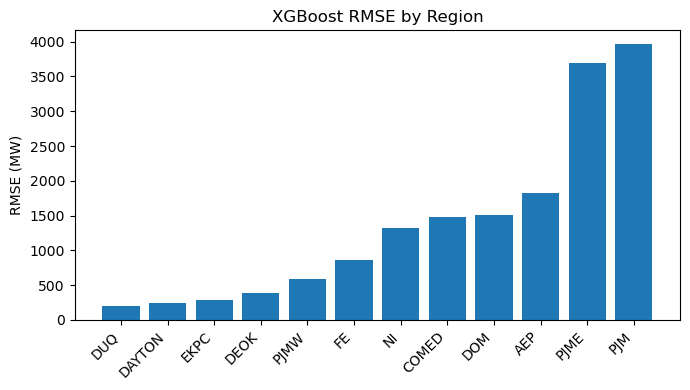

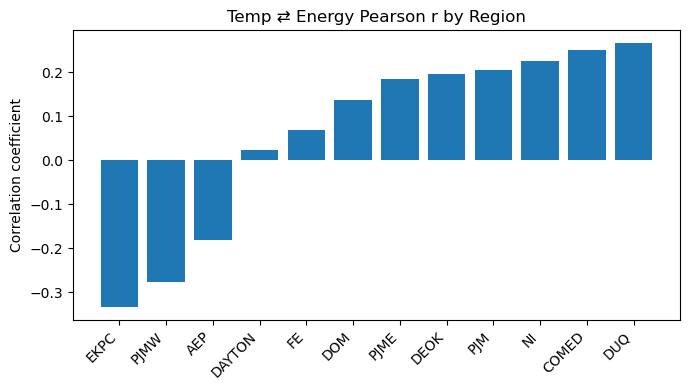

In [5]:
# ───── RMSE bar chart
plt.figure(figsize=(7,4))
regions, rmses = zip(*sorted(region_rmse.items(), key=lambda kv: kv[1]))
plt.bar(regions, rmses)
plt.title("XGBoost RMSE by Region")
plt.ylabel("RMSE (MW)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ───── Correlation bar chart
plt.figure(figsize=(7,4))
regions, corrs = zip(*sorted(region_corr.items(), key=lambda kv: kv[1]))
plt.bar(regions, corrs)
plt.title("Temp ⇄ Energy Pearson r by Region")
plt.ylabel("Correlation coefficient")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()